# k-NN On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. k-NN on k-Fold cross validation<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg Word2Vec & TF-IDF Word2Vec<br>
10. Conclusion<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using k nearest neighbor algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words, TF-IDF, avg Word2Vec, TF-IDF weighted Word2Vec. 

In [4]:
#Importing required libraries
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import nltk
import time
from matplotlib import pyplot as plt 
import seaborn as sns 
from sklearn import neighbors 
from matplotlib.colors import ListedColormap
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc
import warnings 
warnings.filterwarnings('ignore')

In [5]:
from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

#Applying dimensionality reduction 
def truncated_svd(data):
    svd = TruncatedSVD(n_components = 100, random_state = 0)
    svd_val = svd.fit_transform(data)
    return svd_val

## 3. Loading the data

In [7]:
#Loading the data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

Loading the pre-processed data using sqlite. This dataset has no entry with score 3 which is previously removed. And the scores which are greater than 3 are denoted as 'positive' and which are less than 3 are denoted as 'negative' scores.

In [5]:
data.shape

(364171, 12)

In [6]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing 

To apply k-NN, the loaded data still needs further preprocessing. 

In [5]:
from sklearn.utils import resample

df_majority = data[data.Score=='positive']
df_minority = data[data.Score=='negative']
 
#Downsampling majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=57110,  
                                 random_state=1)   
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [6]:
df_downsampled.shape

(114220, 12)

In [7]:
#Sorting the data according to the time-stamp
sorted_data = df_downsampled.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
245,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
308,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
241,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...
296,346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,positive,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,b'beetlejuic wonder amus comed romp explor inc...


In [8]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

## 5. k-NN & k-Fold Cross Validation 

In [9]:
#Defining K-NN on K-Folds 
def cross_val(data):

    global train 
    global test 
    
    train, test = cross_validation.train_test_split(data, test_size=0.3, random_state=0)

    kfold = KFold(3, shuffle=False, random_state=1)

    k_val = np.arange(1,50,3)
    cv_err = []
    test_err = []
    for train_data, cv_data in kfold.split(train):

        for i in k_val:
    
            knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)

            # fitting the model on crossvalidation train
            knn.fit(train[train_data][:,:100], train[train_data][:,100])

            # predict the response on the crossvalidation train
            cv_err.append(1 - (knn.score(train[cv_data][:,:100], train[cv_data][:,100])))
            test_err.append(1 - (knn.score(test[:,:100], test[:,100])))

    return cv_err, test_err

In [10]:
#Ploting errors for cross validation and test set
def error_comparision(cv_err, test_err):
    sns.set()
    k_val = np.arange(1,50,3)
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(k_val, cv_err[i, :],label = 'cv_error')
        plt.plot(k_val, test_err[i, :],label = 'test_error')
        plt.xlabel('K-Values')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TEST-ERR for Fold '+str(i+1))

In [64]:
#Test Accuracy and ROC plot
def final_test_acc(best_k, name):
    knn = KNeighborsClassifier(best_k, n_jobs=-1)
    knn.fit(train[:,:100],train[:,100])
    pred = knn.predict(test[:,:100])
    acc = accuracy_score(test[:,100], pred, normalize=True) * float(100)
    print("\nTest accuracy for k = '{0}' is '{1}'".format(best_k, acc))
    fpr, tpr, thresholds = roc_curve(test[:,100], pred)
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='KNN')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title(str(best_k)+'-NN ROC curve for '+name)
    plt.show()
    print('Area under the ROC curve is ', roc_auc_score(np.array(test[:,100]), pred))
    conf_matx = confusion_matrix(np.array(test[:,100]),pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    plt.figure(figsize=(8,5))
    sns.heatmap(norm_conf_matx, annot=True, xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plt.title('Confusion Matrix Heatmap', fontsize=18)

## 6. Bag of Words (BoW)

In [15]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(sorted_data['CleanedText'].values)

In [16]:
final_counts.shape

(114220, 41258)

In [17]:
#Standardizing the data and then applying dimensionality reduction
tic = time.time()
stnd_bow = standardizer(final_counts)
svd_bow = truncated_svd(stnd_bow)
toc = time.time()
svd_bow.shape
print(toc-tic)

8.469624519348145


In [18]:
svd_bow.shape

(114220, 100)

In [35]:
score = np.array(sorted_data.Score.reshape(114220,1))

In [36]:
score.shape

(114220, 1)

In [21]:
bow =  np.concatenate((svd_bow, score), axis=1)

In [22]:
bow.shape

(114220, 101)

In [24]:
cv_err_bow, test_err_bow = cross_val(bow)

In [25]:
cv_err_bow = np.reshape(cv_err_bow,(3, 17))
test_err_bow = np.reshape(test_err_bow,(3, 17))

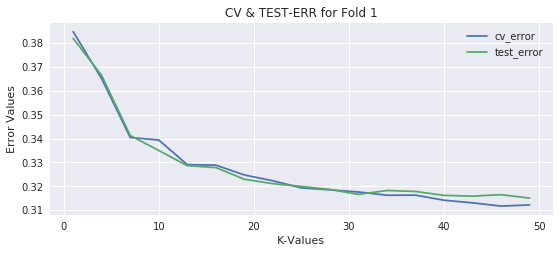

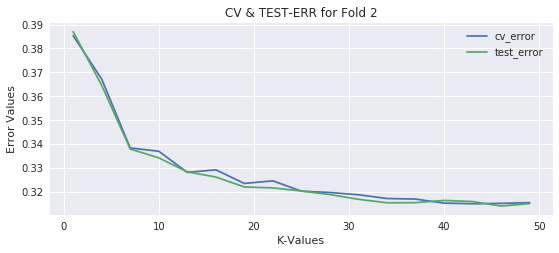

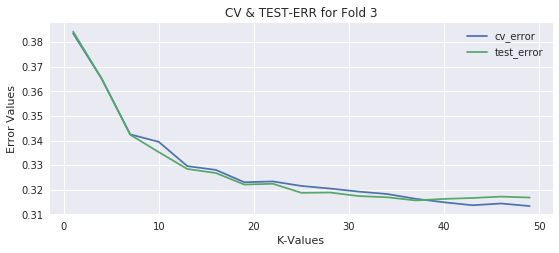

In [26]:
error_comparision(cv_err_bow, test_err_bow)

#### Observation:
* From above cv-error and test-error comparision we spotted the elbow at K value equal to 7.
* So I'm selecting K=7 as the best suitable K for our K-NN model.


Test accuracy for k = '7' is '66.43611743419132'


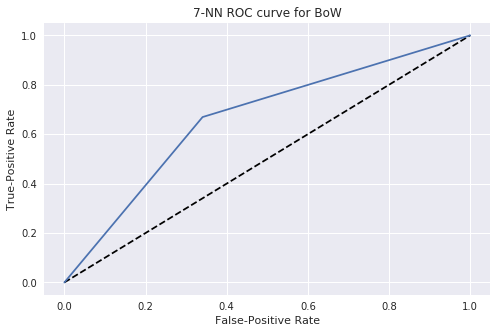

Area under the ROC curve is  0.664392870749877

Confusion Matrix :
 [[11371  5872]
 [ 5629 11394]]

Normalized Confusion Matrix :
 [[0.65945601 0.34494507]
 [0.32645131 0.66932973]]


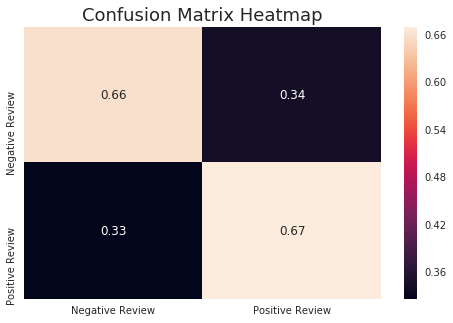

In [35]:
#Plotting ROC curve for 7-NN model 
final_test_acc(7, 'BoW')

#### Observation:
* For K=7 we are getting total accuracy of 66.44%.
* True Positive and True negative rates are also close to 66% which is not enough to classisfy a data confidently.

### 6.1 Bag of Words (Bi-Gram)

In [59]:
#Adding both uni-gram and bi-gram to BoW
count_vect = CountVectorizer(ngram_range=(1,2))
final_bigram_counts = count_vect.fit_transform(sorted_data['CleanedText'].values)

In [61]:
final_bigram_counts.shape

(114220, 1428081)

In [62]:
#Standardizing the data and then applying dimensionality reduction
tic = time.time()
stnd_bigram = standardizer(final_bigram_counts)
svd_bigram = truncated_svd(stnd_bigram)
toc = time.time()
print(toc-tic)

70.36862897872925


In [63]:
svd_bigram.shape

(114220, 100)

In [64]:
bigram =  np.concatenate((svd_bigram, score), axis=1)

In [67]:
bigram.shape

(114220, 101)

In [68]:
cv_err_bigram, test_err_bigram = cross_val(bigram)

In [69]:
cv_err_bigram = np.reshape(cv_err_bigram,(3, 17))
test_err_bigram = np.reshape(test_err_bigram,(3, 17))

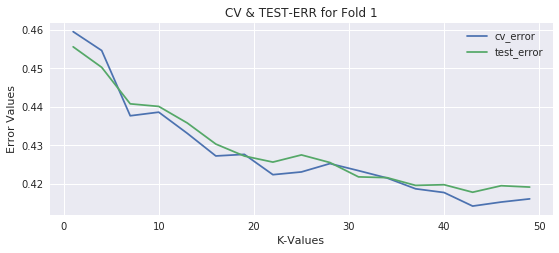

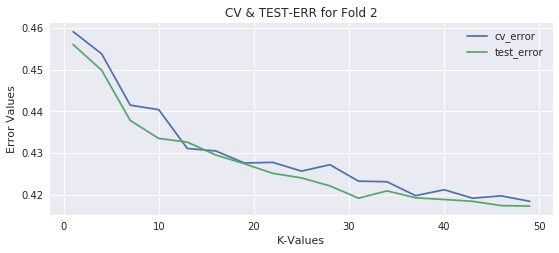

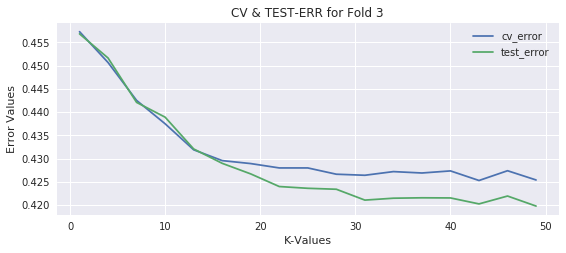

In [72]:
error_comparision(cv_err_bigram, test_err_bigram)

#### Observation:
* From above cv-error and test-error plot we can't find where exactly is the elbow as it is not clear.
* I'm selecting K=13 as the best suitable K, as a little elbow is appeared at K=13 in the Fold 3 plot.


Test accuracy for k = '13' is '67.83108620790289'


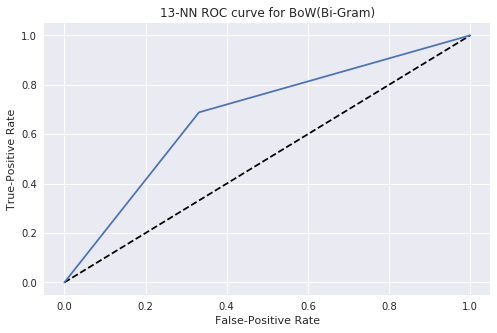

Area under the ROC curve is  0.6783757369396713

Confusion Matrix :
 [[11523  5720]
 [ 5303 11720]]

Normalized Confusion Matrix :
 [[0.66827118 0.33601598]
 [0.30754509 0.68848029]]


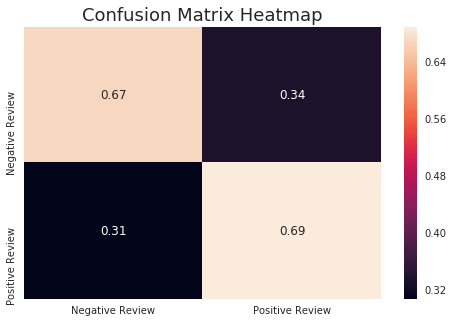

In [76]:
final_test_acc(13, 'BoW(Bi-Gram)')

#### Observation:
* For K=13 we are getting total accuracy of 67.83%.
* True Positive and True negative rates are 69% and 67% which is not enough to classisfy a data confidently.
* BoW(Bi-Gram) is better than BoW(Uni-Gram) in terms of accuracy but still not sufficient to make a difference.

## 7. TF-IDF

In [12]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sorted_data['CleanedText'].values)

In [13]:
print(final_tf_idf.shape)
type(final_tf_idf)

(114220, 1428081)


scipy.sparse.csr.csr_matrix

In [14]:
#Finding such rare words in this corpus along with its tf-idf value
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],tf_idf_vect.get_feature_names(),10)
print(top_tfidf)

         feature     tfidf
0           movi  0.330025
1  action whatev  0.286911
2  comedi action  0.286911
3   movi collect  0.286911
4    fill comedi  0.286911
5      movi movi  0.277178
6   collect fill  0.270273
7       one movi  0.270273
8      want call  0.240202
9         comedi  0.238545


In [15]:
#Standardizing the data and then applying dimensionality reduction
stnd_tf_idf = standardizer(final_tf_idf)
svd_tf_idf = truncated_svd(stnd_tf_idf)
svd_tf_idf.shape

(114220, 100)

In [59]:
svd_tf_idf.shape

(114220, 100)

In [60]:
tf_idf =  np.concatenate((svd_tf_idf, score), axis=1)

In [61]:
tf_idf.shape

(114220, 101)

In [62]:
cv_err_tf_idf, test_err_tf_idf = cross_val(tf_idf)

In [63]:
cv_err_tfidf = np.reshape(cv_err_tf_idf,(3, 17))
test_err_tfidf = np.reshape(test_err_tf_idf,(3, 17))

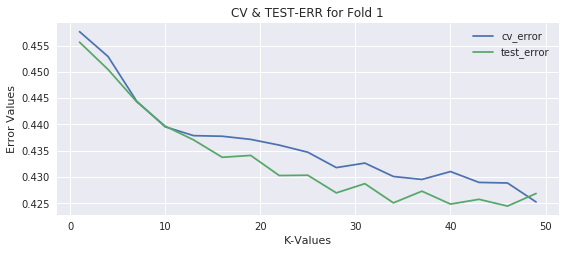

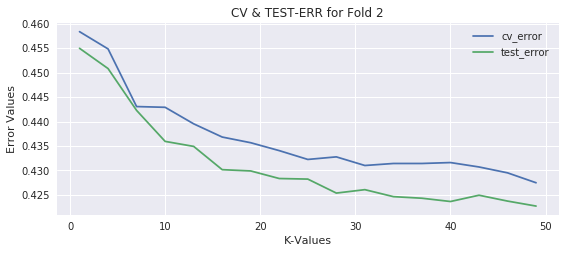

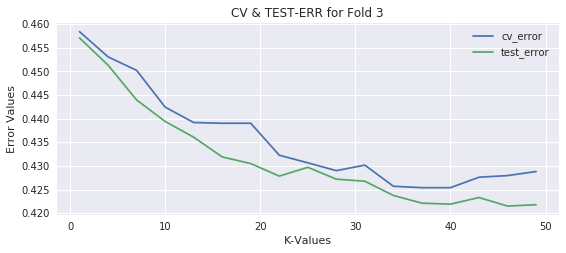

In [64]:
error_comparision(cv_err_tfidf, test_err_tfidf)

#### Observation:
* We are not getting any clear elbow shape in these plots.
* So, I'm selecting K=34 as best K value to model KNN on TF-IDF.


Test accuracy for k = '34' is '57.71026673670694'


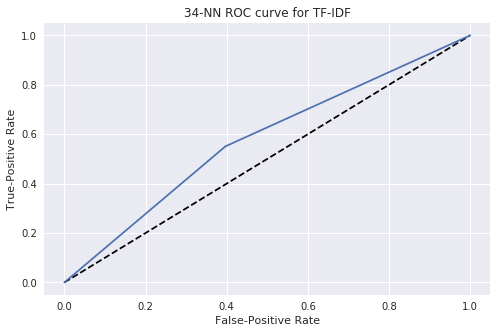

Area under the ROC curve is  0.5769351462904565

Confusion Matrix :
 [[10398  6845]
 [ 7646  9377]]

Normalized Confusion Matrix :
 [[0.60302732 0.40210304]
 [0.44342632 0.55084298]]


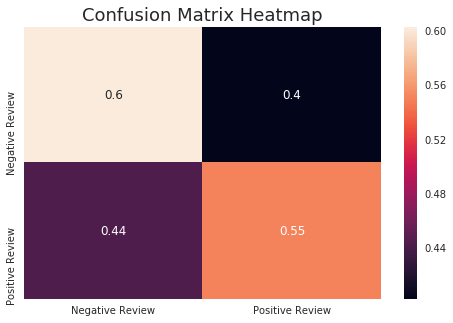

In [67]:
final_test_acc(34, 'TF-IDF')

#### Observation:
* For K=34 we are getting total accuracy of 57.7%.
* True Positive and True negative rates are 55% and 60% which is not all good. As randomly labeling classes shows such type of accuracy.
* So, TF-IDF is not good for this classification task.

## 8. Word2Vec

In [16]:
#Importing Libraries 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [17]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [18]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [50]:
print(sorted_data['Text'].values[0])
print(list_of_sent[0])

Beetlejuice is an excellent and funny movie. Keaton is hilarious as the wacky beetlejuice. The great special effects help the film. I think this is one of the best movies ever made and I'm sure you'll agree. For a good  time, watch beetlejuice!
['beetlejuice', 'is', 'an', 'excellent', 'and', 'funny', 'movie', 'keaton', 'is', 'hilarious', 'as', 'the', 'wacky', 'beetlejuice', 'the', 'great', 'special', 'effects', 'help', 'the', 'film', 'i', 'think', 'this', 'is', 'one', 'of', 'the', 'best', 'movies', 'ever', 'made', 'and', 'im', 'sure', 'youll', 'agree', 'for', 'a', 'good', 'time', 'watch', 'beetlejuice']


In [19]:
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=4)

In [20]:
words = list(w2v_model.wv.vocab)
print(len(words))

20878


## 9. Avg Word2Vec & TF-IDF Word2Vec

In [21]:
#Determining average Word2Vec for each review
sent_vectors = []
for sent in list_of_sent: 
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

114220
100


In [54]:
avg_word2vec = np.matrix(sent_vectors)

In [45]:
stnd_avg_word2vec = standardizer(avg_word2vec)
stnd_avg_word2vec.shape

(114220, 100)

In [46]:
avg_w2v =  np.concatenate((stnd_avg_word2vec, score), axis=1)

In [47]:
avg_w2v.shape

(114220, 101)

In [48]:
cv_err_w2v, test_err_w2v = cross_val(avg_w2v)

In [49]:
cv_err_w2v = np.reshape(cv_err_w2v,(3, 17))
test_err_w2v = np.reshape(test_err_w2v,(3, 17))

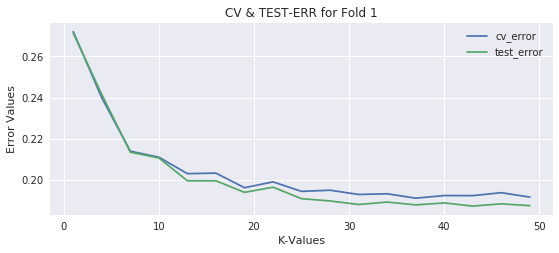

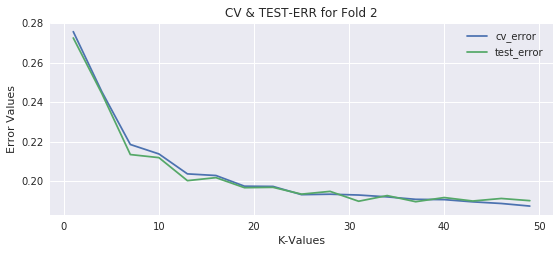

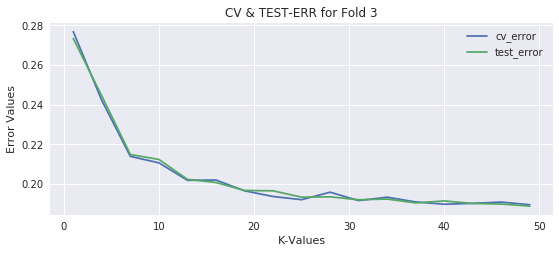

In [50]:
error_comparision(cv_err_w2v, test_err_w2v)

#### Observation:
* From these plots we are getting clear elbow shape which is at K=7.
* So, I'm selecting K=7 for this model.


Test accuracy for k = '7' is '78.83908247242164'


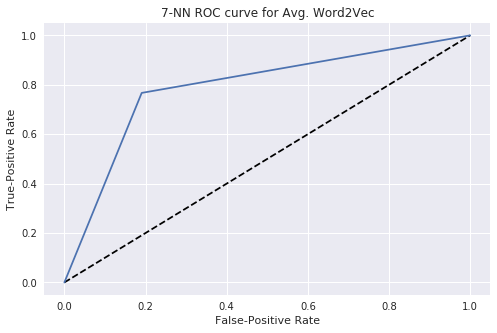

Area under the ROC curve is  0.7882548733775072

Confusion Matrix :
 [[13957  3286]
 [ 3965 13058]]

Normalized Confusion Matrix :
 [[0.80942991 0.19303296]
 [0.22994838 0.76707983]]


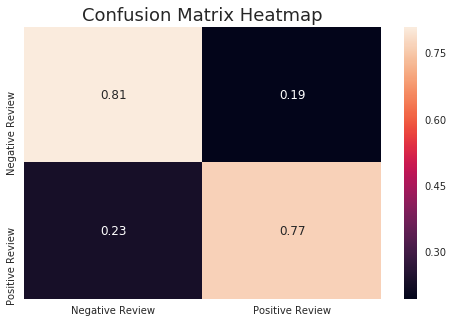

In [51]:
final_test_acc(7, 'Avg. Word2Vec')

#### Observation:
* For K=7 we are getting total accuracy of 78.82%.
* True Positive and True negative rates are good, which is 77% and 81%.
* K-NN Performs better for average word2vec than that of BoW and TF-IDF.

### 9.1 TF-IDF weighted Word2Vec

In [29]:
# Determining TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() 

tfidf_sent_vectors = []
row = 0
tic = time.time()
for sent in list_of_sent[:10000]: 
    sent_vec = np.zeros(100)
    weight_sum = 0 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
toc = time.time()
print(toc - tic)

49868.18654847145


In [30]:
tfidf_word2vec = np.matrix(tfidf_sent_vectors)

In [31]:
tfidf_word2vec.shape

(10000, 100)

In [32]:
where_are_NaNs = np.isnan(tfidf_word2vec)
tfidf_word2vec[where_are_NaNs] = 0

In [33]:
np.any(np.isnan(tfidf_word2vec))

False

In [37]:
tfidf_word2vec =  np.concatenate((tfidf_word2vec, score[:10000]), axis=1)

In [2]:
tfidf_word2vec.shape

(10000, 101)

In [12]:
cv_err_tfw2v, test_err_tfw2v = cross_val(tfidf_word2vec)

In [13]:
cv_err_w2v_tfidf = np.reshape(cv_err_tfw2v,(3, 17))
test_err_w2v_tfidf = np.reshape(test_err_tfw2v,(3, 17))

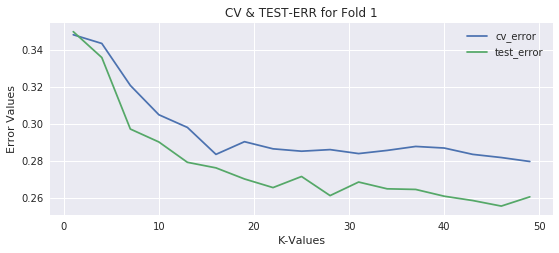

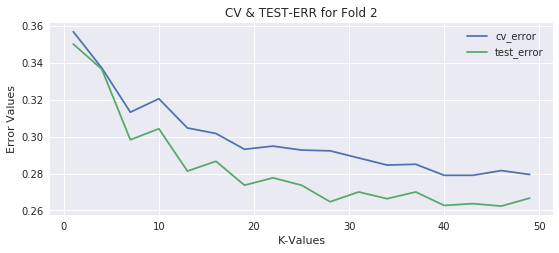

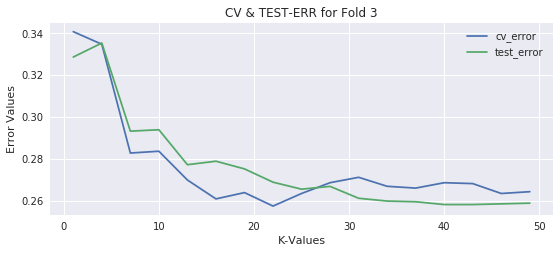

In [14]:
error_comparision(cv_err_w2v_tfidf, test_err_w2v_tfidf)

#### Observation:
* From the above plots there is no clear elbow shape.
* So, I'm selecting K=28, as K=28 on errors are flattening out.


Test accuracy for k = '28' is '74.13333333333333'


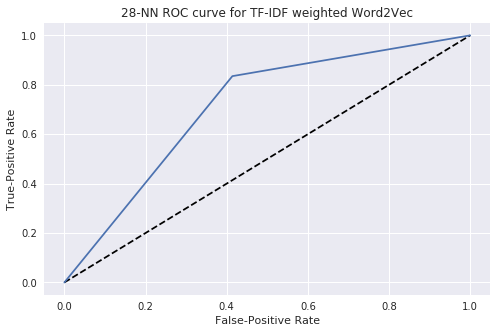

Area under the ROC curve is  0.710464402618658

Confusion Matrix :
 [[ 661  467]
 [ 309 1563]]

Normalized Confusion Matrix :
 [[0.58599291 0.41400709]
 [0.1650641  0.8349359 ]]


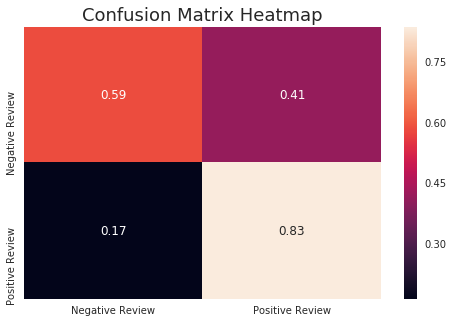

In [65]:
final_test_acc(28, 'TF-IDF weighted Word2Vec')

#### Observation:
* For K=28 we are getting total accuracy of 74.13%
* But from the confusion matrix it is clear that K-NN classifies negative classes poorly for TF-IDF weighed Word2Vec.
* It seems like the model is biased towards positive reviews and assigns posive class mostly for the give data. 

## 10. Conclusion:
* K-NN algorithm's performance for text classification is better than average but not that good.
* In our case K-NN performs better(i.e ~ 79%) for Avg-Word2Vec representation of text data.
* As text-data is very high dimensional in nature so algorithms like K-NN which uses euclidean distance as distance metric performs poor as in high dimension euclidean distance behaves strangely.